# The impact of the potential RFR scenario on surface-atmosphere exchange.

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May 5 2023
Mapping terrestrial-atmosphere exchange in simulations and calculate uncertainty ranges in reforestation numbers
@author: arifeinberg
"""

'\nCreated on Fri May 5 2023\nMapping terrestrial-atmosphere exchange in simulations and calculate uncertainty ranges in reforestation numbers\n@author: arifeinberg\n'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import scipy.io as sio
import datetime
import xarray as xr
from helper_functions import ds_sel_yr, annual_avg, open_Hg
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as colors

### load area and masks

In [5]:
# Load grid cell area for unit conversion of model
fn_gbox = '/mnt/data-summer-user/analysis_scripts/misc_Data/GEOSChem_2x25_gboxarea.nc'
ds_gbox = xr.open_dataset(fn_gbox)
gbox_GC = ds_gbox.cell_area #m2

### Load emissions fluxes

In [6]:
sim = ['0311','0314']
sim_name = ['HIST', 'RFR']

# initialize matrices
balance = []
soil_emiss_a = []
dd_Hg0_a = []
dep_total_a = []
other_flux_a = []

# run loop
for i in range(len(sim)):
    sim_i = sim[i]
    fn_emis = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.MercuryEmis.2015_m.nc4'
    ds_emis = xr.open_dataset(fn_emis)
    lon = ds_emis.lon
    lat = ds_emis.lat
    soil_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0soil', 2015) 
    land_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0land', 2015) 
    geogen_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0geogenic', 2015) 
    bb_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0biomass', 2015) 
    ant0_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0anthro', 2015) 
    ant2_emis_yr = ds_sel_yr(ds_emis, 'EmisHg2HgPanthro', 2015) 
    ocean_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0ocean', 2015) 
    
    
    # Convert model data from kg/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    
    unit_conv = s_in_yr
        
    soil_emis = annual_avg(soil_emis_yr) * unit_conv # kg/yr
    land_emis = annual_avg(land_emis_yr) * unit_conv # kg/yr
    geogen_emis = annual_avg(geogen_emis_yr) * unit_conv # kg/yr
    bb_emis = annual_avg(bb_emis_yr) * unit_conv # kg/yr
    ant0_emis = annual_avg(ant0_emis_yr) * unit_conv # kg/yr
    ant2_emis = annual_avg(ant2_emis_yr) * unit_conv # kg/yr
    ocean_emis = annual_avg(ocean_emis_yr) * unit_conv # kg/yr
    
    # Load deposition fluxes
    # dry dep
    fn_dd = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.DryDep.2015_m.nc4'
    ds_dd = xr.open_dataset(fn_dd)
    
    dd_Hg0_yr = ds_sel_yr(ds_dd, 'DryDep_Hg0', 2015) 
    dd_Hg2_yr = ds_sel_yr(ds_dd, 'DryDep_Hg2', 2015) 
    dd_HgP_yr = ds_sel_yr(ds_dd, 'DryDep_HgP', 2015) 
    
    # Convert model data from molec/cm2/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    g_kg = 1e-3 # g in kg
    cm2_m2 = 1e4 # cm^2 in m^2
    MW_Hg = 200.59 # g mol^-1
    avo = 6.02e23 # avogadro number molec mol^-1
    
    unit_conv = MW_Hg / avo * g_kg * cm2_m2 * s_in_yr * gbox_GC # constant to convert units
    
    dd_Hg0 = annual_avg(dd_Hg0_yr) * unit_conv # kg/yr
    dd_Hg2 = annual_avg(dd_Hg2_yr) * unit_conv # kg/yr
    dd_HgP = annual_avg(dd_HgP_yr) * unit_conv # kg/yr
    
    # wet dep
    fn_dd = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.WetLossTotal.2015_m.nc4'
    ds_dd = xr.open_dataset(fn_dd)
    
    wd_Hg_yr = ds_sel_yr(ds_dd, 'WetLossTot_Hg', 2015) 
    
    # Convert model data from kg/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    
    unit_conv = s_in_yr
    
    wd_Hg = annual_avg(wd_Hg_yr) * unit_conv # kg/yr

    # sea salt loss 
    fn_ss = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.MercuryChem.2015_m.nc4'
    ds_ss = xr.open_dataset(fn_ss)
    
    ss_Hg2_yr = ds_sel_yr(ds_ss, 'LossHg2bySeaSalt_v', 2015) 
    
    # Convert model data from kg/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    
    unit_conv = s_in_yr
    
    ss_Hg2 = annual_avg(ss_Hg2_yr) * unit_conv # kg/yr
    
    # totals emiss, dep, balance
    emiss_total = soil_emis + land_emis + geogen_emis + bb_emis + ant0_emis + ant2_emis + ocean_emis # kg/yr
    dep_total = dd_Hg0 + dd_Hg2 + dd_HgP + wd_Hg + ss_Hg2 # kg/yr
    
    # other fluxes, not including dd_Hg0 and soil_emis
    other_flux = land_emis + geogen_emis + bb_emis + ant0_emis + ant2_emis - dd_Hg2 - dd_HgP - wd_Hg - ss_Hg2
    
    balance.append((emiss_total - dep_total)) # kg/yr
    dd_Hg0_a.append(dd_Hg0) # kg/yr
    soil_emiss_a.append(soil_emis) # kg/yr
    dep_total_a.append(dep_total) # kg/yr
    other_flux_a.append(other_flux) # kg/yr

### Shift pcolormesh lat and lon

In [7]:
# extend longitude by 2
lon_extend = np.zeros(lon.size+2)
# fill in internal values
lon_extend[1:-1] = lon # fill up with original values
# fill in extra endpoints
lon_extend[0] = lon[0]-np.diff(lon)[0]
lon_extend[-1] = lon[-1]+np.diff(lon)[-1]
# calculate the midpoints
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

# extend latitude by 2
lat_extend = np.zeros(lat.size+2)
# fill in internal values
lat_extend[1:-1] = lat
# fill in extra endpoints
lat_extend[0] = lat[0]-np.diff(lat)[0]
lat_extend[-1] = lat[-1]+np.diff(lat)[-1]
# calculate the midpoints
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

### Plot map plots

Diff over land
<xarray.DataArray ()> Size: 8B
array(-97.86702976)
total dep over land
<xarray.DataArray ()> Size: 8B
array(3045.88746263)
Diff over sea
<xarray.DataArray ()> Size: 8B
array(89.3460225)
total dep over sea
<xarray.DataArray ()> Size: 8B
array(4120.51191597)


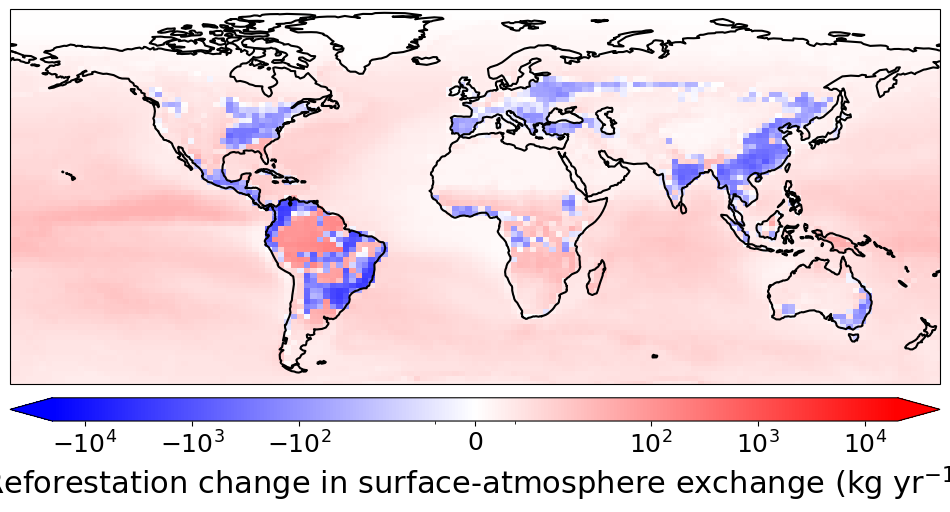

In [8]:
lat_min = -60
lat_max = 85
Change_balance = balance[1]-balance[0]
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.cm.bwr
f, ax1 = plt.subplots(1, 1, figsize=[12,6],subplot_kw=dict(projection=ccrs.PlateCarree()),
                              gridspec_kw=dict(hspace=0., wspace=0.1))

h = ax1.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints,
                   Change_balance, cmap =cmap,
                   norm=colors.SymLogNorm(linthresh=30, linscale=1,
                                              vmin=-2e4, vmax=2e4),
                   rasterized = True)
#cbar.tick_params(labelsize=14)
ax1.set_ylim([lat_min, lat_max])
# ax1.set_title('Impact of reforestation on surface-atmosphere exchange', fontweight='bold', fontsize=17)
# ax1.text(0.0, 1.04, 'a', fontweight='bold',fontsize=17,
#              horizontalalignment='left', verticalalignment='center',
#              transform=ax1.transAxes)

ax1.coastlines(linewidth=1.5)
#f.subplots_adjust(bottom=0.4)

cbar = plt.colorbar(h, extend='both',orientation='horizontal',
                    ticks=[-10000, -1000, -100,0, 100, 1000, 10000 ],
                    ax=ax1, aspect=40, pad=0.03)
cbar.set_label('Reforestation change in surface-atmosphere exchange (kg yr$^{-1}$)', fontsize = 22)
cbar.ax.tick_params(labelsize=18) 
f.savefig('/home/jovyan/colomb_ige-m2-internship-2025_MERCAMAZON-project/figures/map_diff.pdf',bbox_inches = 'tight')
#%% Calculate land sink difference
Change_balance = balance[1]-balance[0]

# Load land mask
fn_sea = '/mnt/data-summer-user/analysis_scripts/misc_Data/seamask_geos2x25.nc'
ds_s = xr.open_dataset(fn_sea)
mask_s = ds_s.topo
diff_best = (Change_balance * mask_s).sum()/1000.
print("Diff over land")
print(diff_best)
print("total dep over land")
print((dep_total_a[0] * mask_s).sum()/1000.)

fn_land = '/mnt/data-summer-user/analysis_scripts/misc_Data/landmask_geos2x25.nc'
ds_l = xr.open_dataset(fn_land)
mask_l = ds_l.sea
print("Diff over sea")
print((Change_balance * mask_l).sum()/1000.)
print("total dep over sea")
print((dep_total_a[0] * mask_l).sum()/1000.)

Other_HIST_land = (other_flux_a[0] * mask_s).sum().values/1000.
Other_RFR_land = (other_flux_a[1] * mask_s).sum().values/1000.

### Load uncertainty simulations results

In [9]:
HIST_emiss_unc =  np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_global_emiss_HIST_v2.csv", delimiter=",")
HIST_dep_unc =  np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_dep_HIST_global_all_land.csv", delimiter=",")

RFR_emiss_unc =  np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_global_emiss_RFR.csv", delimiter=",")
RFR_dep_unc =  np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_dep_RFR_global_all_land.csv", delimiter=",")

# lower bound
diff_unc_25 = np.percentile(HIST_emiss_unc - RFR_emiss_unc, 2.5) + \
                np.percentile(RFR_dep_unc - HIST_dep_unc,2.5) + \
                    (Other_HIST_land - Other_RFR_land)
# upper bound
diff_unc_975 = np.percentile(HIST_emiss_unc - RFR_emiss_unc, 97.5) + \
                np.percentile(RFR_dep_unc - HIST_dep_unc,97.5) + \
                    (Other_HIST_land - Other_RFR_land)
                    
print("Lower bound RFR: 2.5th percentile:")
print(diff_unc_25)
print("Upper bound RFR: 97.5th percentile:")
print(diff_unc_975)
print("Best estimate RFR:")
print(-diff_best.values)

Lower bound RFR: 2.5th percentile:
64.06478412780498
Upper bound RFR: 97.5th percentile:
449.3995726760292
Best estimate RFR:
97.8670297593998


### Calculate total over different latitude ranges

In [10]:
change_only_land = (Change_balance*mask_s) # kg/yr
change_only_land_lat = change_only_land.sum("lon")/1000 # Mg/yr
print("Extratropical NH emissions saved:")
print(change_only_land_lat.sel(lat=slice(15,90)).sum().values)
print("Tropical emissions saved:")
print(change_only_land_lat.sel(lat=slice(-15,15)).sum().values)
print("Extratropical SH emissions saved:")
print(change_only_land_lat.sel(lat=slice(-90,-15)).sum().values)

# Calculate South Amercian reforestation opportunities  
change_only_land_SA = change_only_land.sel(lat=slice(-60,15),lon=slice(-83,-23))/1000
print("South American emissions saved:")
print(change_only_land_SA.sum(["lat","lon"]).values)

Extratropical NH emissions saved:
-29.25714643807763
Tropical emissions saved:
-30.5043630951425
Extratropical SH emissions saved:
-38.10552022617966
South American emissions saved:
-70.59616806938483
